# FoNS Datathon 2021 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import *


In [2]:
train_descriptors = pd.read_csv("train_descriptors.csv")
train_mord3d = pd.read_csv("train_mord3d.csv")
train_morgan = pd.read_csv("train_morgan.csv")
train_rdk = pd.read_csv("train_rdk.csv")

train_crystals = pd.read_csv("train_crystals.csv")
train_distances = pd.read_csv("train_distances.csv")
train_centroid_distances = pd.read_csv("train_centroid_distances.csv")

In [3]:
test_descriptors = pd.read_csv("test_descriptors.csv")
test_mord3d = pd.read_csv("test_mord3d.csv")
test_morgan = pd.read_csv("test_morgan.csv")
test_rdk = pd.read_csv("test_rdk.csv")

### Data pre-processing

In [4]:
train_descriptors_full = train_descriptors.iloc[:, 3:-2].dropna(axis= 1, how="any")
# remove missing values (NA)
train_descriptors_full.shape
# return the dimensionality of the data

(13449, 984)

In [5]:
train_descriptors_full.iloc[:,3:-2].dropna

<bound method DataFrame.dropna of        nBase    SpAbs_A   SpMax_A  SpDiam_A     SpAD_A   SpMAD_A   LogEE_A  \
0          0  14.599164  2.244739  4.388162  14.599164  1.216597  3.370933   
1          0  18.488707  2.357869  4.715737  18.488707  1.232580  3.592641   
2          0  16.685332  2.436274  4.872549  16.685332  1.191809  3.577079   
3          0  12.857279  2.214320  4.428639  12.857279  1.285728  3.188884   
4          0  11.638727  2.249778  4.311276  11.638727  1.163873  3.200300   
...      ...        ...       ...       ...        ...       ...       ...   
13444      0  18.593111  2.444247  4.716186  18.593111  1.239541  3.643609   
13445      0  15.070075  2.071027  4.107492  15.070075  1.255840  3.352283   
13446      0  13.246202  2.248763  4.497527  13.246202  1.204200  3.286342   
13447      0  17.683997  2.402187  4.804373  17.683997  1.263143  3.571058   
13448      0  17.004191  2.270288  4.540576  17.004191  1.214585  3.520641   

          VE1_A     VE2_A    

In [6]:
test_descriptors_full = test_descriptors[train_descriptors_full.columns]
test_descriptors_full.shape

(3363, 984)

In [7]:
train_PCA = decomposition.PCA(n_components=.95)
# dimensionality reduction for PCS
scaler_for_PCA = preprocessing.StandardScaler()
# standardise features - remove the mean and scale according to unit var 
# especially useful for SVMs, which assumes a gaussian fit
train_descriptors_PCA = train_PCA.fit_transform(scaler_for_PCA.fit_transform(train_descriptors_full))
test_descriptors_PCA = train_PCA.transform(scaler_for_PCA.transform(test_descriptors_full))
print(train_descriptors_PCA.shape, test_descriptors_PCA.shape)

(13449, 124) (3363, 124)


In [11]:
train_PCA?

Nested CV 

### A (very!!) simple and bad model

In [8]:
target = "calculated_density"
# model = linear_model.LinearRegression()
model = svm.SVR(kernel = 'rbf', gamma = 0.1, epsilon = .1)
# svr_lin = svm.SVR(kernel = 'linear', C = 100, gamma = 'auto')
# svr_poly - SVR(kernel = 'poly', C = 100, gamma = 'auto', degree=3, epsilon = 0.1, coef0 = 1)
# svrs=[svr_rbf, svr_lin, svr_poly]
model.fit(train_descriptors_PCA, train_crystals[target])

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

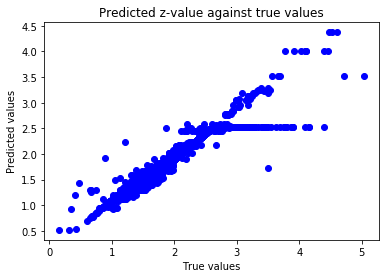

In [9]:
predictions = model.predict(train_descriptors_PCA)
plt.plot(train_crystals[target], predictions, "bo")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("Predicted z-value against true values")
plt.show()

### Cross-validation to evaluate the model's performance

In [14]:
cv_scores = model_selection.cross_val_score(
    model, 
    train_descriptors_PCA, 
    train_crystals[target], 
    scoring="neg_mean_absolute_error",
    cv = 5)

print("Average negative MAE:", round(np.mean(cv_scores), 3))
print("Standard deviation:", round(np.std(cv_scores), 3))

Average negative MAE: -0.188
Standard deviation: 0.005


### Outputting predictions for automated checking 
Link: https://github.com/stevenkbennett/fons_datathon_testing

In [10]:
predictions = model.predict(test_descriptors_PCA)

In [11]:
np.savetxt("task_x_predictions.csv", predictions)
# Alternatively, if using pandas, you can use the following:
pd.DataFrame(predictions).to_csv("task_x_predictions.csv", header=False, index=False)